In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/ML - 2567/Project /DiseasesInDurianLeaf/DurianLeaf

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/ML - 2567/Project /DiseasesInDurianLeaf/DurianLeaf


In [ ]:
# นำเข้าไลบรารีที่จำเป็น
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3, ResNet50V2, VGG19, MobileNetV2, Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os
import shutil
import random

# Set parameters

In [ ]:
# พารามิเตอร์สำคัญ
IMG_SIZE = (224, 224)  # ขนาดภาพที่ต้องการ
BATCH_SIZE = 32  # ขนาด Batch
EPOCHS = 10  # จำนวนรอบการฝึก

# Prepare Data Directories

In [ ]:
# Define the base directory where your images are stored
_base_dir = '/content/drive/MyDrive/Colab Notebooks/ML - 2567/Project /DiseasesInDurianLeaf/DurianLeaf'
categories = ['Anthracnose', 'No disease', 'Rust fungus']
split_ratios = {'train': 0.7, 'val': 0.2, 'test': 0.1}

# Define output directories for Train, Val, and Test sets
output_dirs = {
    'train': '/content/drive/MyDrive/Colab Notebooks/ML - 2567/Project /DiseasesInDurianLeaf/DurianLeaf/train',
    'val': '/content/drive/MyDrive/Colab Notebooks/ML - 2567/Project /DiseasesInDurianLeaf/DurianLeaf/val',
    'test': '/content/drive/MyDrive/Colab Notebooks/ML - 2567/Project /DiseasesInDurianLeaf/DurianLeaf/test'
}

In [ ]:
# Function to create output directories and remove them if they already exist
def create_output_dirs(output_dirs, categories):
    for split_dir in output_dirs.values():
        # If the directory exists, remove it and create a new one
        if os.path.exists(split_dir):
            shutil.rmtree(split_dir)  # Remove the directory and all its contents
        os.makedirs(split_dir)  # Recreate the base split directory

        # Create subdirectories for each category (normal, positive)
        for category in categories:
            category_path = os.path.join(split_dir, category)
            os.makedirs(category_path)  # Create category directory

In [ ]:
# Remove and recreate the output directories
create_output_dirs(output_dirs, categories)

In [ ]:
# Function to split the data into train, validation, and test sets
def split_data(category, source_dir, output_dirs, split_ratios):
    # List all files in the source directory
    files = os.listdir(source_dir)
    # Shuffle the files randomly to ensure randomness
    random.shuffle(files)
    total_files = len(files)

    # Calculate the number of files for training, validation, and testing
    train_size = int(split_ratios['train'] * total_files)
    val_size = int(split_ratios['val'] * total_files)

    # Slice the file list into train, validation, and test sets
    train_files = files[:train_size]
    val_files = files[train_size:train_size + val_size]
    test_files = files[train_size + val_size:]

    # Copy files to their respective directories
    for file in train_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(output_dirs['train'], category))
    for file in val_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(output_dirs['val'], category))
    for file in test_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(output_dirs['test'], category))

# Split the files for each category (normal, positive)
for category in categories:
    source_dir = os.path.join(_base_dir, category)
    split_data(category, source_dir, output_dirs, split_ratios)

print("Data split completed")

Data split completed


# Prepare data with ImageDataGenerator

In [ ]:
# สร้างออบเจ็กต์ ImageDataGenerator สำหรับ Rescale ค่า Pixel
datagen = ImageDataGenerator(rescale=1.0/255)

# โหลดข้อมูลชุด Train
train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/ML - 2567/Project /DiseasesInDurianLeaf/DurianLeaf/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# โหลดข้อมูลชุด Validation
val_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/ML - 2567/Project /DiseasesInDurianLeaf/DurianLeaf/val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# โหลดข้อมูลชุด Test (ไม่ต้อง Shuffle)
test_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/ML - 2567/Project /DiseasesInDurianLeaf/DurianLeaf/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 513 images belonging to 3 classes.
Found 145 images belonging to 3 classes.
Found 77 images belonging to 3 classes.


#1.Load and Customize InceptionV3

In [ ]:
# Select the model from https://keras.io/api/applications/#available-models

# โหลดโมเดล InceptionV3 ที่ไม่รวม top layer (pre-trained บน ImageNet)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# แช่แข็งเลเยอร์เดิมเพื่อป้องกันการฝึกซ้ำ
for layer in base_model.layers:
    layer.trainable = False

# เพิ่มเลเยอร์ใหม่สำหรับการจำแนกประเภท
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(128, activation='relu')(x)  # เพิ่ม Dense Layer
predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Output Layer

# สร้างโมเดลใหม่
model = Model(inputs=base_model.input, outputs=predictions)

# คอมไพล์โมเดล
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ดูสรุปของโมเดล
model.summary()


## Train model

In [ ]:
# ฝึกโมเดล
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 223s 10s/step - accuracy: 0.5492 - loss: 1.0412 - val_accuracy: 0.9172 - val_loss: 0.2086
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 180s 8s/step - accuracy: 0.9293 - loss: 0.2001 - val_accuracy: 0.9241 - val_loss: 0.1918
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 210s 9s/step - accuracy: 0.9577 - loss: 0.1083 - val_accuracy: 0.9448 - val_loss: 0.1359
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 200s 9s/step - accuracy: 0.9853 - loss: 0.0658 - val_accuracy: 0.9655 - val_loss: 0.1004
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 197s 9s/step - accuracy: 0.9880 - loss: 0.0409 - val_accuracy: 0.9655 - val_loss: 0.0901
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 188s 9s/step - accuracy: 0.9984 - loss: 0.0260 - val_accuracy: 0.9655 - val_loss: 0.0811
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 199s 8s/step - accuracy: 1.0000 - loss: 0.0173 - val_accuracy: 0.9586 - val_loss: 0.0950
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 199s 9s/step - accuracy: 1.0000 - loss: 0.0164 - val_accuracy: 0.9655 - val_loss: 0

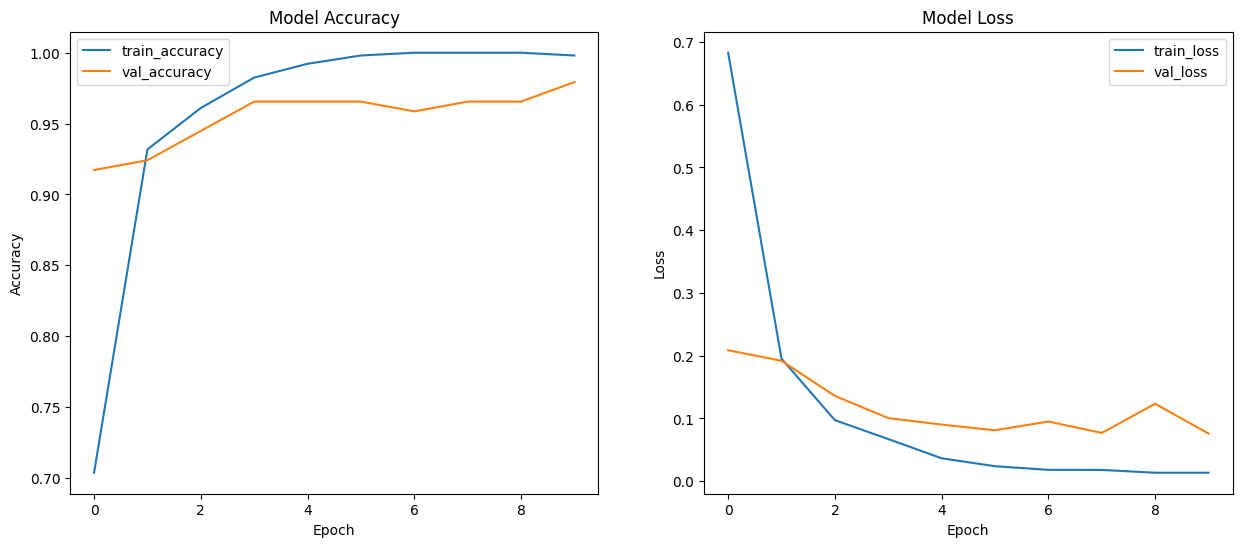

In [ ]:
import matplotlib.pyplot as plt

# แสดงกราฟ Accuracy
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


# แสดงกราฟ Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.show()


## Evaluate Model with Test dataset

In [ ]:
# ประเมินผลโมเดล
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.9896 - loss: 0.0389
Test Accuracy: 98.70%


# 2.Load and Customize ResNet50V2

In [ ]:
# โหลดโมเดล ResNet50V2 ที่ไม่รวม top layer (pre-trained บน ImageNet)
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Select the model from https://keras.io/api/applications/#available-models


# แช่แข็งเลเยอร์เดิมเพื่อป้องกันการฝึกซ้ำ
for layer in base_model.layers:
    layer.trainable = False

# เพิ่มเลเยอร์ใหม่สำหรับการจำแนกประเภท
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(128, activation='relu')(x)  # เพิ่ม Dense Layer
predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Output Layer

# สร้างโมเดลใหม่
model = Model(inputs=base_model.input, outputs=predictions)

# คอมไพล์โมเดล
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ดูสรุปของโมเดล
model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 23,827,459 (90.89 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

## Train Model

In [ ]:
# ฝึกโมเดล
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 248s 12s/step - accuracy: 0.5924 - loss: 1.2256 - val_accuracy: 0.9448 - val_loss: 0.1471
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 236s 10s/step - accuracy: 0.9862 - loss: 0.0774 - val_accuracy: 0.9793 - val_loss: 0.0778
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 271s 11s/step - accuracy: 0.9927 - loss: 0.0327 - val_accuracy: 0.9724 - val_loss: 0.0786
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 225s 11s/step - accuracy: 0.9981 - loss: 0.0196 - val_accuracy: 0.9793 - val_loss: 0.0741
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 285s 12s/step - accuracy: 1.0000 - loss: 0.0078 - val_accuracy: 0.9724 - val_loss: 0.0746
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 233s 11s/step - accuracy: 1.0000 - loss: 0.0082 - val_accuracy: 0.9655 - val_loss: 0.0791
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 211s 10s/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 0.9793 - val_loss: 0.0773
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 267s 11s/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.

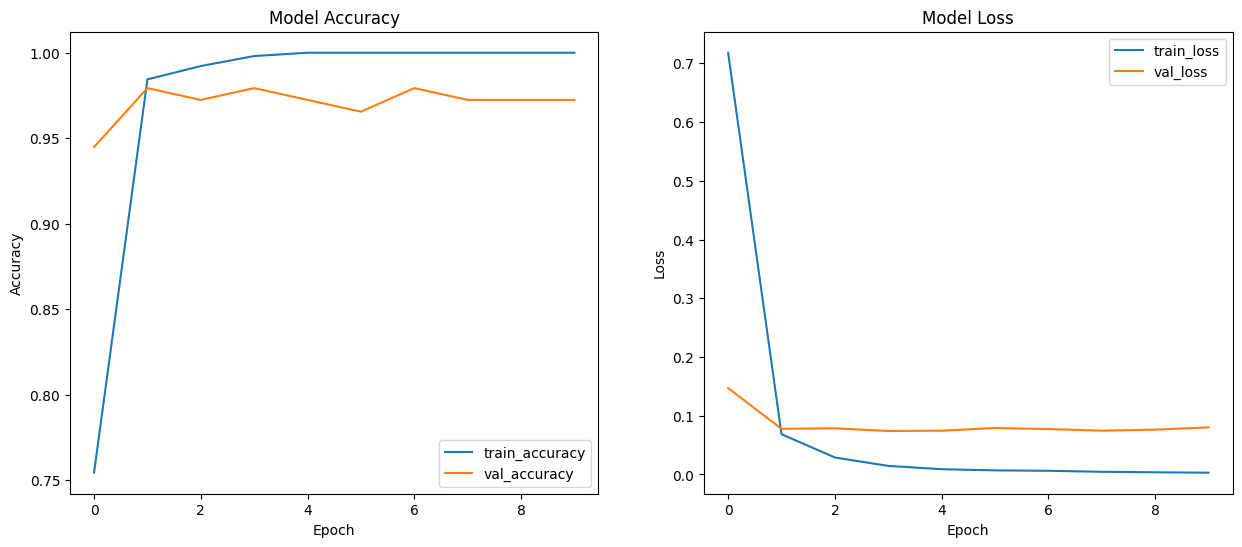

In [ ]:
import matplotlib.pyplot as plt

# แสดงกราฟ Accuracy
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


# แสดงกราฟ Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.show()

## Evaluate Model with Test dataset

In [ ]:
# ประเมินผลโมเดล
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step - accuracy: 1.0000 - loss: 0.0152
Test Accuracy: 100.00%


#3.Load and Customize VGG19

In [ ]:
# โหลดโมเดล ResNet50V2 ที่ไม่รวม top layer (pre-trained บน ImageNet)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Select the model from https://keras.io/api/applications/#available-models


# แช่แข็งเลเยอร์เดิมเพื่อป้องกันการฝึกซ้ำ
for layer in base_model.layers:
    layer.trainable = False

# เพิ่มเลเยอร์ใหม่สำหรับการจำแนกประเภท
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(128, activation='relu')(x)  # เพิ่ม Dense Layer
predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Output Layer

# สร้างโมเดลใหม่
model = Model(inputs=base_model.input, outputs=predictions)

# คอมไพล์โมเดล
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ดูสรุปของโมเดล
model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,090,435 (76.64 MB)

 Trainable params: 66,051 (258.01 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

## Train Model

In [ ]:
# ฝึกโมเดล
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 650s 36s/step - accuracy: 0.3315 - loss: 1.1857 - val_accuracy: 0.3379 - val_loss: 1.0128
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 634s 35s/step - accuracy: 0.4241 - loss: 0.9852 - val_accuracy: 0.8483 - val_loss: 0.8397
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 631s 35s/step - accuracy: 0.8411 - loss: 0.8298 - val_accuracy: 0.8276 - val_loss: 0.7412
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 689s 35s/step - accuracy: 0.7988 - loss: 0.7251 - val_accuracy: 0.7172 - val_loss: 0.6860
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 679s 35s/step - accuracy: 0.7819 - loss: 0.6824 - val_accuracy: 0.8276 - val_loss: 0.5923
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 690s 39s/step - accuracy: 0.8851 - loss: 0.5845 - val_accuracy: 0.8621 - val_loss: 0.5272
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 639s 36s/step - accuracy: 0.9079 - loss: 0.5174 - val_accuracy: 0.8828 - val_loss: 0.4812
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 681s 36s/step - accuracy: 0.8820 - loss: 0.4677 - val_accuracy: 0.

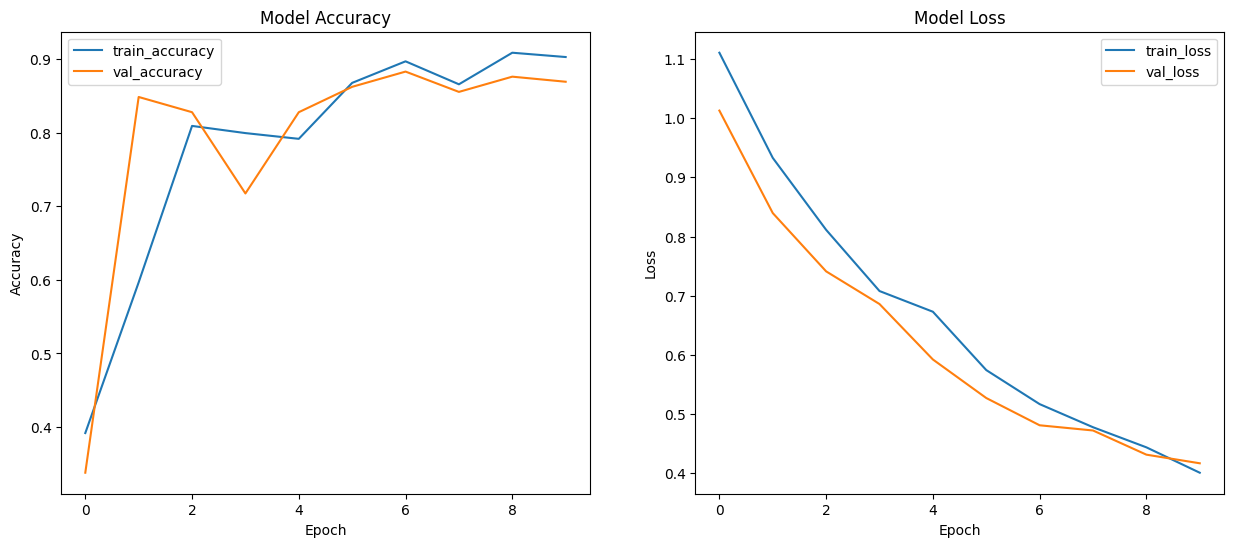

In [ ]:
import matplotlib.pyplot as plt

# แสดงกราฟ Accuracy
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


# แสดงกราฟ Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.show()

## Evaluate Model with Test dataset

In [ ]:
# ประเมินผลโมเดล
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 73s 19s/step - accuracy: 0.9480 - loss: 0.3647
Test Accuracy: 93.51%


#4.Load and Customize MobileNetV2

In [ ]:
# โหลดโมเดล ResNet50V2 ที่ไม่รวม top layer (pre-trained บน ImageNet)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Select the model from https://keras.io/api/applications/#available-models


# แช่แข็งเลเยอร์เดิมเพื่อป้องกันการฝึกซ้ำ
for layer in base_model.layers:
    layer.trainable = False

# เพิ่มเลเยอร์ใหม่สำหรับการจำแนกประเภท
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(128, activation='relu')(x)  # เพิ่ม Dense Layer
predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Output Layer

# สร้างโมเดลใหม่
model = Model(inputs=base_model.input, outputs=predictions)

# คอมไพล์โมเดล
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ดูสรุปของโมเดล
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Train Model

In [ ]:
# ฝึกโมเดล
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 145s 6s/step - accuracy: 0.6733 - loss: 0.8489 - val_accuracy: 0.9310 - val_loss: 0.1480
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.9694 - loss: 0.1023 - val_accuracy: 0.9586 - val_loss: 0.0948
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 135s 5s/step - accuracy: 0.9893 - loss: 0.0330 - val_accuracy: 0.9517 - val_loss: 0.0776
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 135s 5s/step - accuracy: 0.9966 - loss: 0.0259 - val_accuracy: 0.9655 - val_loss: 0.0735
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.9861 - loss: 0.0302 - val_accuracy: 1.0000 - val_loss: 0.0524
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - accuracy: 0.9970 - loss: 0.0187 - val_accuracy: 0.9724 - val_loss: 0.0633
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 148s 6s/step - accuracy: 0.9984 - loss: 0.0117 - val_accuracy: 0.9655 - val_loss: 0.0803
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 146s 6s/step - accuracy: 1.0000 - loss: 0.0076 - val_accuracy: 0.9793 - v

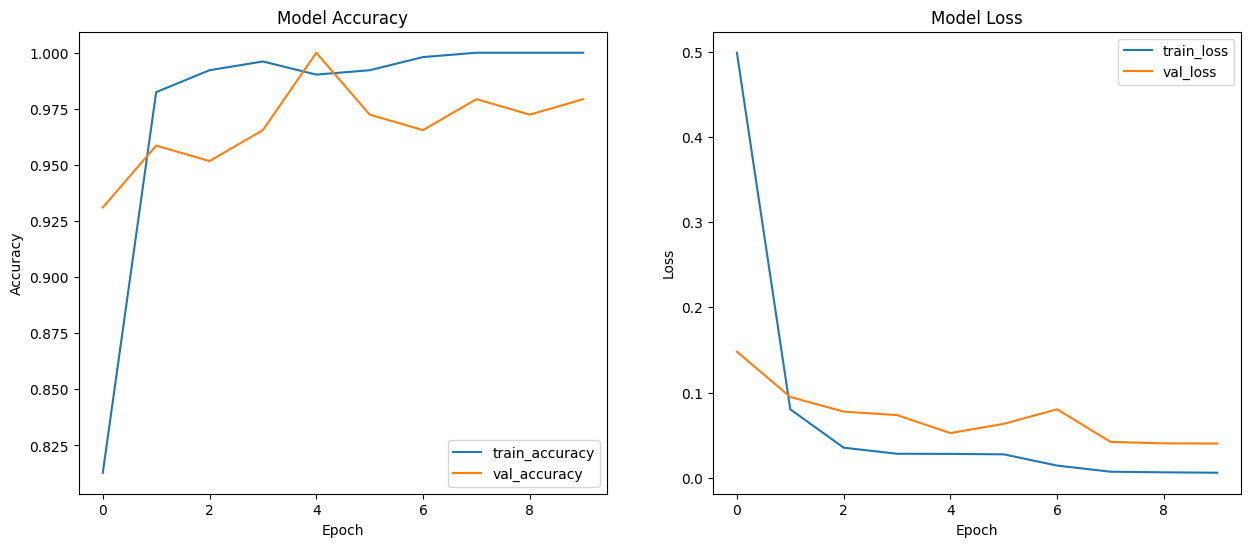

In [ ]:
import matplotlib.pyplot as plt

# แสดงกราฟ Accuracy
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


# แสดงกราฟ Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.show()

## Evaluate Model with Test dataset

In [ ]:
# ประเมินผลโมเดล
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.9818 - loss: 0.0601
Test Accuracy: 98.70%


#5.Load and Customize Xception

In [ ]:
# โหลดโมเดล ResNet50V2 ที่ไม่รวม top layer (pre-trained บน ImageNet)
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Select the model from https://keras.io/api/applications/#available-models


# แช่แข็งเลเยอร์เดิมเพื่อป้องกันการฝึกซ้ำ
for layer in base_model.layers:
    layer.trainable = False

# เพิ่มเลเยอร์ใหม่สำหรับการจำแนกประเภท
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(128, activation='relu')(x)  # เพิ่ม Dense Layer
predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Output Layer

# สร้างโมเดลใหม่
model = Model(inputs=base_model.input, outputs=predictions)

# คอมไพล์โมเดล
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ดูสรุปของโมเดล
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_188 (Conv2D)       │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 21,124,139 (80.58 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

## Train Model

In [ ]:
# ฝึกโมเดล
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 279s 13s/step - accuracy: 0.5639 - loss: 0.9837 - val_accuracy: 0.9034 - val_loss: 0.2702
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 313s 13s/step - accuracy: 0.9253 - loss: 0.2208 - val_accuracy: 0.9379 - val_loss: 0.1552
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 256s 13s/step - accuracy: 0.9663 - loss: 0.1052 - val_accuracy: 0.9586 - val_loss: 0.1179
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 263s 13s/step - accuracy: 0.9945 - loss: 0.0659 - val_accuracy: 0.9586 - val_loss: 0.1120
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 314s 13s/step - accuracy: 0.9953 - loss: 0.0508 - val_accuracy: 0.9655 - val_loss: 0.0979
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 264s 13s/step - accuracy: 0.9984 - loss: 0.0297 - val_accuracy: 0.9586 - val_loss: 0.0857
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 253s 13s/step - accuracy: 1.0000 - loss: 0.0275 - val_accuracy: 0.9655 - val_loss: 0.0718
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 267s 13s/step - accuracy: 0.9969 - loss: 0.0170 - val_accuracy: 0.

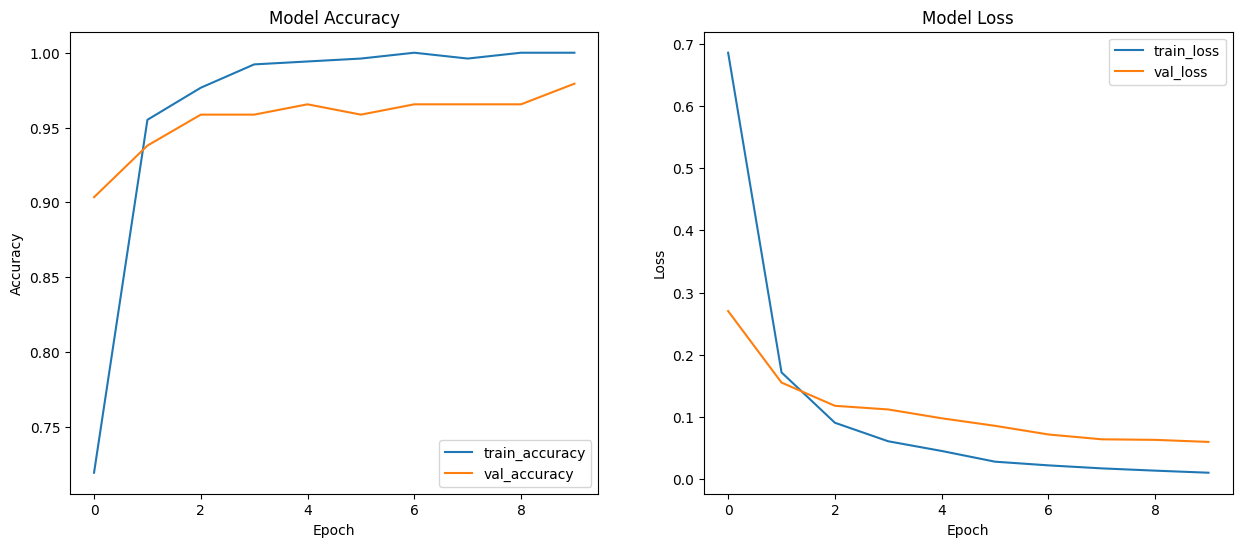

In [ ]:
import matplotlib.pyplot as plt

# แสดงกราฟ Accuracy
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


# แสดงกราฟ Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.show()

## Evaluate Model with Test dataset

In [ ]:
# ประเมินผลโมเดล
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 32s 7s/step - accuracy: 0.9831 - loss: 0.0689
Test Accuracy: 97.40%
